In [1]:
import numpy as np
from zat.log_to_dataframe import LogToDataFrame 
import zat
import pandas as pd
import matplotlib.pyplot as plt 


In [26]:
# import files etc
dataset_path = "./data/"
log_to_df = LogToDataFrame()
conn_df = log_to_df.create_dataframe(dataset_path + "conn.log")
dns_df = log_to_df.create_dataframe(dataset_path + "dns.log")
http_df = log_to_df.create_dataframe(dataset_path + "http.log")
ssl_df = log_to_df.create_dataframe(dataset_path + "ssl.log")
files_df = log_to_df.create_dataframe(dataset_path + "files.log")

# reset index for all dataframes
conn_df.reset_index(inplace=True)
dns_df.reset_index(inplace=True)
http_df.reset_index(inplace=True)
ssl_df.reset_index(inplace=True)
files_df.reset_index(inplace=True)


/Users/jakubtehlar/Documents/CTU/MGR/stratosphere/work_challenge/files/ML_ch/stratosphere_ml_challenge/.venv/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:1163: RuntimeWarning: invalid value encountered in cast
  int_data = data.astype(np.int64)


## EDA
- timestamps
- unique DNS/hosts/IPs/domains
- traffic volume over time
- number of connections per minute
- DNS reqs per minute
- bytes sent/received 
- periodic communication

In [28]:
# explore the conn_df
conn_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0 days 00:00:00.010542,31,...,SF,NaN,NaN,0,Dd,1,59,1,108,NaN
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0 days 00:00:00.010908,33,...,SF,NaN,NaN,0,Dd,1,61,1,115,NaN
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0 days 00:00:00.010734,50,...,SF,NaN,NaN,0,Dd,1,78,1,94,NaN
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0 days 00:00:00.010405,37,...,SF,NaN,NaN,0,Dd,1,65,1,119,NaN
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0 days 00:00:00.009332,40,...,SF,NaN,NaN,0,Dd,1,68,1,108,NaN


In [29]:
conn_df.describe()

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,223,223.0,223.0,190,190.0,190.0,223.0,223.0,223.0,223.0,223.0
mean,2020-09-02 14:48:23.848390656,42422.663677,3103.076233,0 days 00:01:06.408112805,6458.863158,186627.715789,0.0,74.789238,9729.116592,132.03139,168489.753363
min,2020-09-02 14:33:23.796334982,3.0,4.0,0 days 00:00:00.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2020-09-02 14:35:18.751427584,38248.0,53.0,0 days 00:00:00.010982,37.0,64.0,0.0,1.0,65.0,1.0,81.0
50%,2020-09-02 14:38:52.271037184,47812.0,443.0,0 days 00:00:03.003519500,482.0,293.5,0.0,3.0,180.0,1.0,148.0
75%,2020-09-02 15:04:43.380082432,52304.0,5228.0,0 days 00:00:39.887839500,1749.75,3727.0,0.0,15.0,2201.0,13.0,3368.5
max,2020-09-02 15:36:57.062417030,65449.0,57736.0,0 days 00:30:08.665546,692835.0,18081893.0,0.0,6927.0,731444.0,13717.0,18795185.0
std,NaN,16515.438133,8078.990258,0 days 00:02:52.760371969,51082.396905,1401233.614579,0.0,503.116911,56719.860387,986.536878,1352416.032459


In [ ]:
conn_df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents'],
      dtype='str')

In [31]:
all_dfs = [conn_df, dns_df, http_df, ssl_df, files_df]

for df in all_dfs:
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}, Time range from {df['ts'].min()} to {df['ts'].max()}")

Rows: 223, Columns: 21, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:36:57.062417030
Rows: 64, Columns: 24, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:27:20.297641993
Rows: 25, Columns: 30, Time range from 2020-09-02 14:33:23.810384989 to 2020-09-02 15:05:59.264569043
Rows: 78, Columns: 21, Time range from 2020-09-02 14:33:48.338402033 to 2020-09-02 15:27:20.309696913
Rows: 70, Columns: 25, Time range from 2020-09-02 14:33:51.558053017 to 2020-09-02 15:05:59.382664919


In [39]:
# timestamps
start_time = conn_df["ts"].min() 
end_time = conn_df["ts"].max()
print(f"Start time: {start_time}, End time: {end_time}")

Start time: 2020-09-02 14:33:23.796334982, End time: 2020-09-02 15:36:57.062417030


In [36]:
# Unique DNS
dns_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,15630,0 days 00:00:00.010542,portal.fb.com,...,0,NOERROR,F,F,T,T,0,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000",F
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,35052,0 days 00:00:00.010908,i.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000",F
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,55600,0 days 00:00:00.010734,scontent-prg1-1.cdninstagram.com,...,0,NOERROR,F,F,T,T,0,157.240.30.63,59.000000,F
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,39507,0 days 00:00:00.010405,graph.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000",F
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,41491,0 days 00:00:00.009332,edge-mqtt.facebook.com,...,0,NOERROR,F,F,T,T,0,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000",F


In [ ]:
# queries
dns_df["query"].unique()

['portal.fb.com', 'i.instagram.com', 'scontent-prg1-1.cdninstagram.com', 'graph.instagram.com', 'edge-mqtt.facebook.com', ..., 'android.clients.google.com', 'mtalk.google.com', 'play.googleapis.com', 'app-measurement.com', 'people-pa.googleapis.com']
Length: 46
Categories (46, str): ['android-safebrowsing.google.com', 'android.clients.google.com', 'android.googleapis.com', 'api-24-0-0.twitter.com', ..., 'video.twimg.com', 'www.facebook.com', 'www.googleapis.com', 'www.msftconnecttest.com']

In [42]:
# DNS servers
dns_df["id.resp_h"].unique()

['8.8.8.8']
Categories (1, str): ['8.8.8.8']

In [43]:
# Client IPs
dns_df["id.orig_h"].unique()

['10.8.0.117']
Categories (1, str): ['10.8.0.117']

Text(0.5, 1.0, 'Number of connections per domain query')

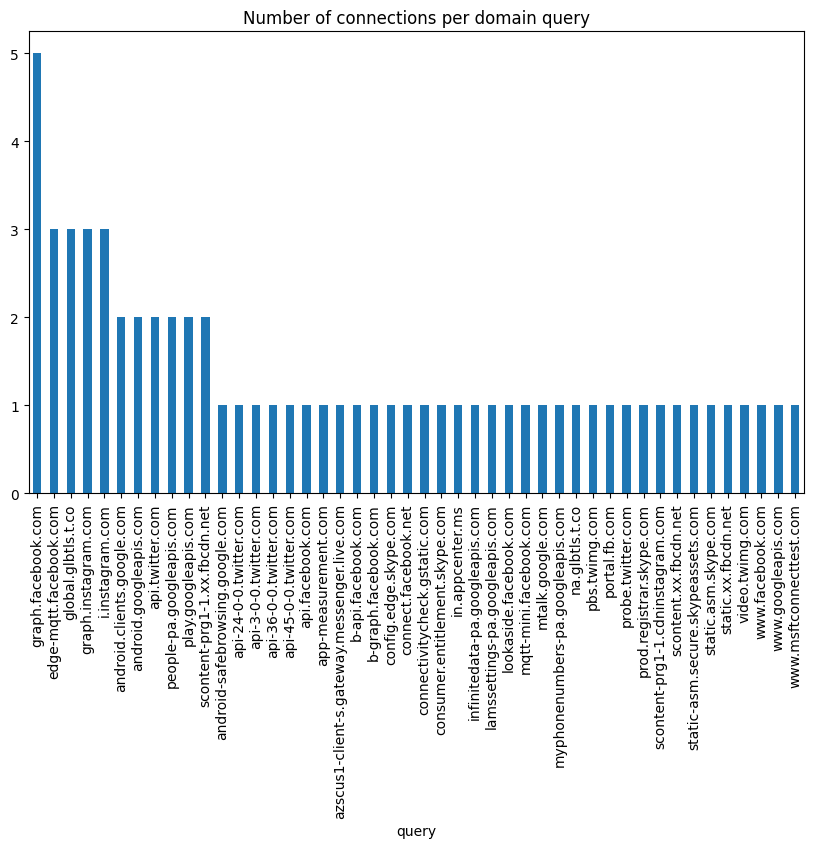

In [45]:
# Plot of connections for each domain query
counts = dns_df["query"].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Number of connections per domain query")
